In [9]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models
import cv2

In [10]:
model = models.vgg16(pretrained = True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
model = model.features

In [12]:
count = 0
for parameter in model.parameters():
  count += 1

print(count)

26


In [13]:
# Freeze gradients because we do not need to update them.
for parameter in model.parameters():
  parameter.requires_grad_(False)

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [15]:
def preprocess_image(img_path, max_size = 400, shape = None):

    image = Image.open(img_path).convert("RGB")
    plt.imshow(image)
    # print(image.size) 640 * 640

    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        size = shape

    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))]) # ImageNet standard AVG. and Variance
    image = transform(image).unsqueeze(0)

    return image

torch.Size([1, 3, 400, 400])


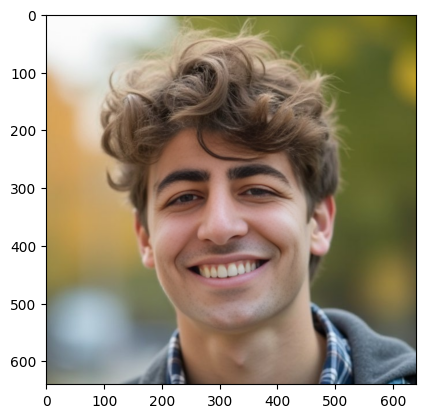

In [16]:
main_img = preprocess_image("1.jpg").to(device)
print(main_img.shape)

torch.Size([1, 3, 400, 400])


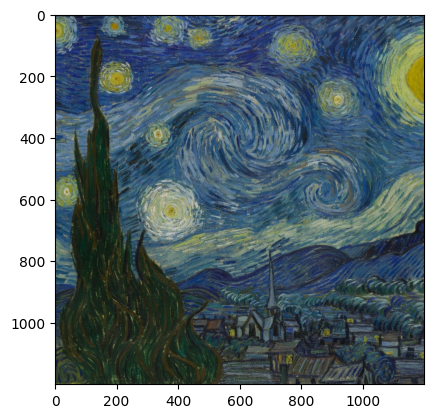

In [17]:
style_img = preprocess_image("2.jpg", shape=main_img.shape[2:]).to(device) # Resize the style image to match the main image.
print(style_img.shape)

In [18]:
# Reverse notmalizing
def converter(tensor):
  img = tensor.clone().detach()
  img = img.numpy().squeeze() # Delete the batch dimension
  img = img.transpose(1, 2, 0)
  img = img * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406)) # Undo normalization
  img = img.clip(0, 1)

  return img

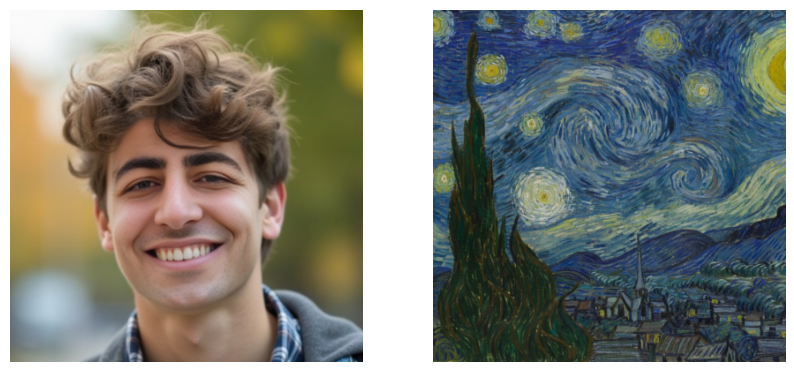

In [19]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(converter(main_img.cpu()))
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(converter(style_img.cpu()))
plt.axis("off");

In [20]:
model = model.to(device)
print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [32]:
def feature_extract(image, model, layers=None):

    if layers is None:
        layers = {
            "0": "conv1_1",
            "5": "conv2_1",
            "10": "conv3_1",
            "19": "conv4_1",
            "21": "conv4_2",
            "28": "conv5_1"
            }


    features = {}
    x = image

    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features

In [23]:
# Calculate the gram matrix.
# Gram is a way to describe the style of an image.

def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h*w)
    gram = torch.mm(tensor, tensor.t()) # Product of tensor and its transpose to calculate correlation.
    return gram

In [24]:
main_features = feature_extract(main_img, model)
main_features

{'conv1_1': tensor([[[[1.7490e-01, 6.6115e-01, 6.6115e-01,  ..., 1.7357e-02,
            2.1734e-02, 0.0000e+00],
           [0.0000e+00, 4.4165e-01, 4.4165e-01,  ..., 3.1082e-01,
            3.0702e-01, 0.0000e+00],
           [0.0000e+00, 4.4165e-01, 4.4165e-01,  ..., 3.1061e-01,
            3.1082e-01, 0.0000e+00],
           ...,
           [2.2339e-01, 3.3752e-01, 3.4257e-01,  ..., 2.6947e-01,
            2.6302e-01, 1.1182e+00],
           [2.4334e-01, 3.4637e-01, 3.4507e-01,  ..., 3.0035e-01,
            2.7112e-01, 1.1135e+00],
           [3.1890e-01, 3.7013e-01, 3.7258e-01,  ..., 5.7598e-02,
            2.4992e-02, 5.5719e-01]],
 
          [[6.9980e+00, 1.8535e+00, 1.8535e+00,  ..., 0.0000e+00,
            0.0000e+00, 1.5142e+00],
           [6.2246e+00, 4.4328e-01, 4.4328e-01,  ..., 3.0736e-01,
            3.0282e-01, 2.5233e+00],
           [6.2246e+00, 4.4328e-01, 4.4328e-01,  ..., 3.1935e-01,
            3.0736e-01, 2.5067e+00],
           ...,
           [5.9525e-01, 5.2

In [26]:
style_features = feature_extract(style_img, model)
style_features

{'conv1_1': tensor([[[[0.0000, 0.6485, 0.8517,  ..., 0.4341, 0.5586, 1.5482],
           [0.0000, 0.2020, 0.6085,  ..., 0.2251, 0.4458, 1.9257],
           [0.0000, 0.0000, 0.2094,  ..., 0.2506, 0.5188, 1.9977],
           ...,
           [0.0000, 0.5862, 0.2599,  ..., 0.3153, 0.4270, 0.7687],
           [0.0000, 0.5623, 0.4367,  ..., 0.3455, 0.5264, 0.7025],
           [0.0000, 0.6255, 0.6884,  ..., 0.3051, 0.4377, 0.5109]],
 
          [[1.3429, 1.8616, 2.1574,  ..., 1.0700, 1.3545, 1.5091],
           [0.0000, 0.0000, 0.0000,  ..., 0.8443, 1.2375, 1.8127],
           [0.0000, 0.0731, 0.1915,  ..., 0.3997, 0.7500, 1.7216],
           ...,
           [0.0000, 0.5247, 0.6924,  ..., 0.0000, 0.1830, 2.6977],
           [0.0000, 0.7179, 0.6973,  ..., 0.4550, 0.7022, 2.3442],
           [0.2194, 1.8770, 1.7895,  ..., 1.5638, 1.5708, 2.3288]],
 
          [[0.6370, 1.2303, 1.4711,  ..., 2.3812, 2.0933, 2.2086],
           [0.0000, 0.0000, 0.0000,  ..., 0.8070, 1.3676, 2.1975],
           [0

In [29]:
style_grams = {layer : gram_matrix(style_features[layer]) for layer in style_features}
style_grams["conv1_1"].shape

torch.Size([64, 64])

In [30]:
t = main_img.clone().requires_grad_(True)
t = t.to(device)

In [33]:
style_weights = {
    "conv1_1": 1.,
    "conv2_1": 0.8,
    "conv3_1": 0.5,
    "conv4_1": 0.3,
    "conv5_1": 0.1
    }

content_weight = 1
style_weight = 1e6

Total loss 4836960.0


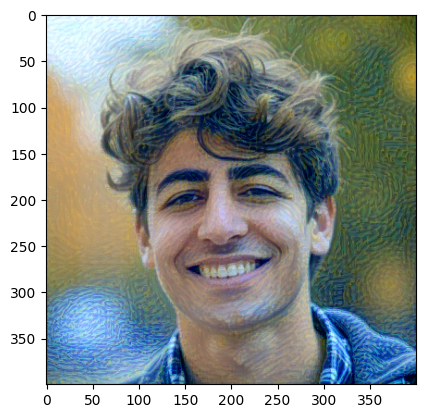

Total loss 2074964.125


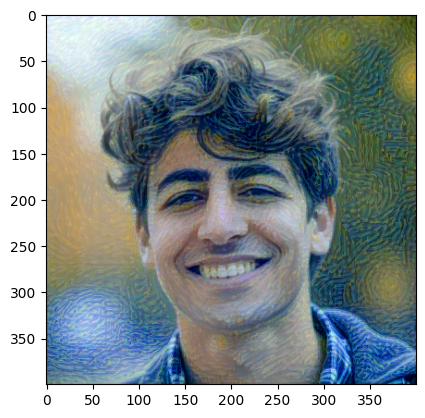

Total loss 1195860.625


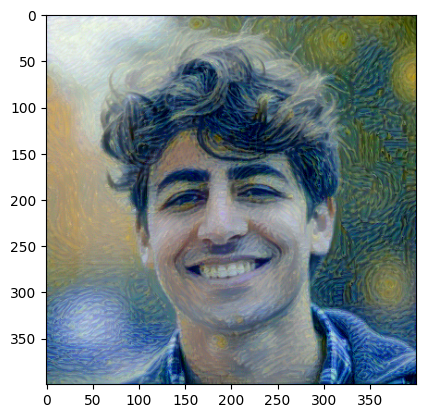

Total loss 779667.4375


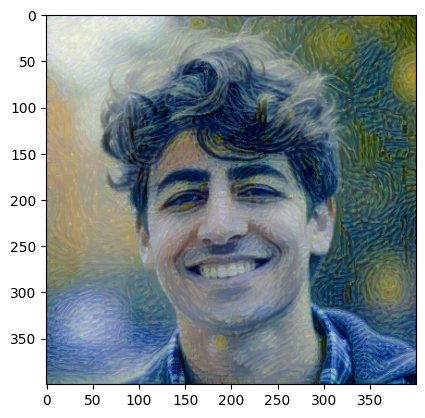

Total loss 528766.3125


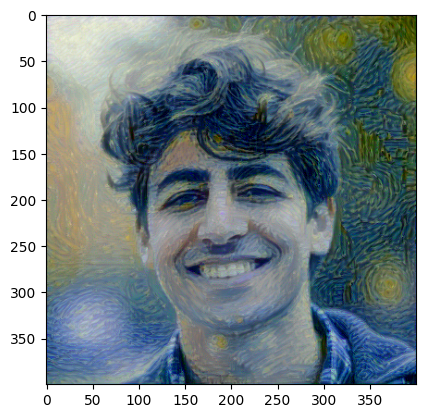

Total loss 365116.46875


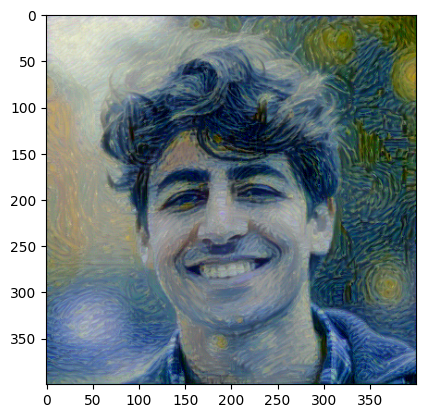

Total loss 256985.109375


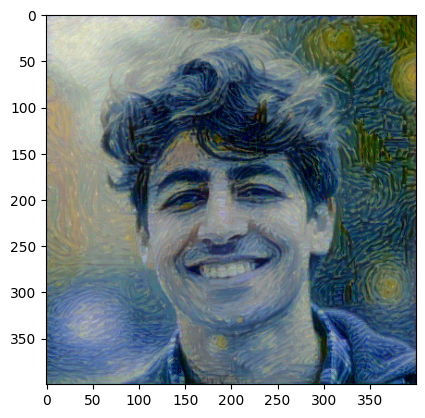

Total loss 183818.0


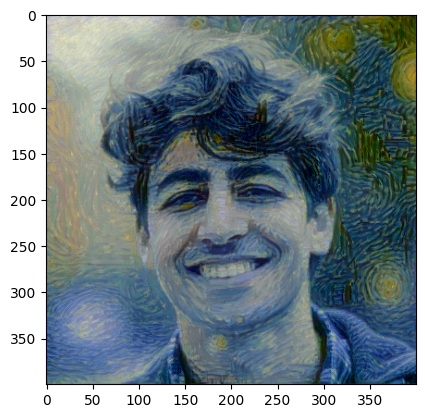

Total loss 133337.625


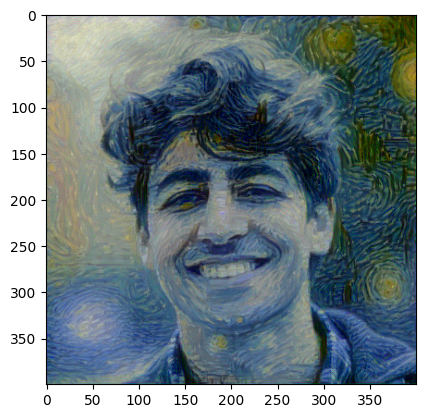

Total loss 97789.625


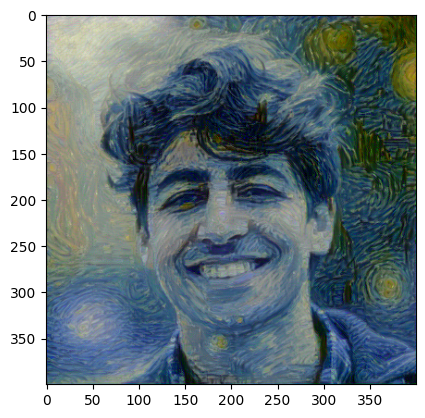

In [34]:
show_every = 500
optimizer = optim.Adam([t], lr= 0.005)
steps = 5000

for step in range(1, steps+1):
    target_features = feature_extract(t, model)
    content_loss = torch.mean((target_features["conv4_2"] - main_features["conv4_2"])**2)

    style_loss = 0

    for layer in style_weights:
        target_feature = target_features[layer]
        _, d, h, w = target_feature.size()

        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)

        style_loss += layer_style_loss /(d*h*w)

    total_loss = (content_weight * content_loss) + (style_weight * style_loss)

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if step % show_every == 0:
        print("Total loss", total_loss.item())
        plt.imshow(converter(t.cpu()))
        plt.show()

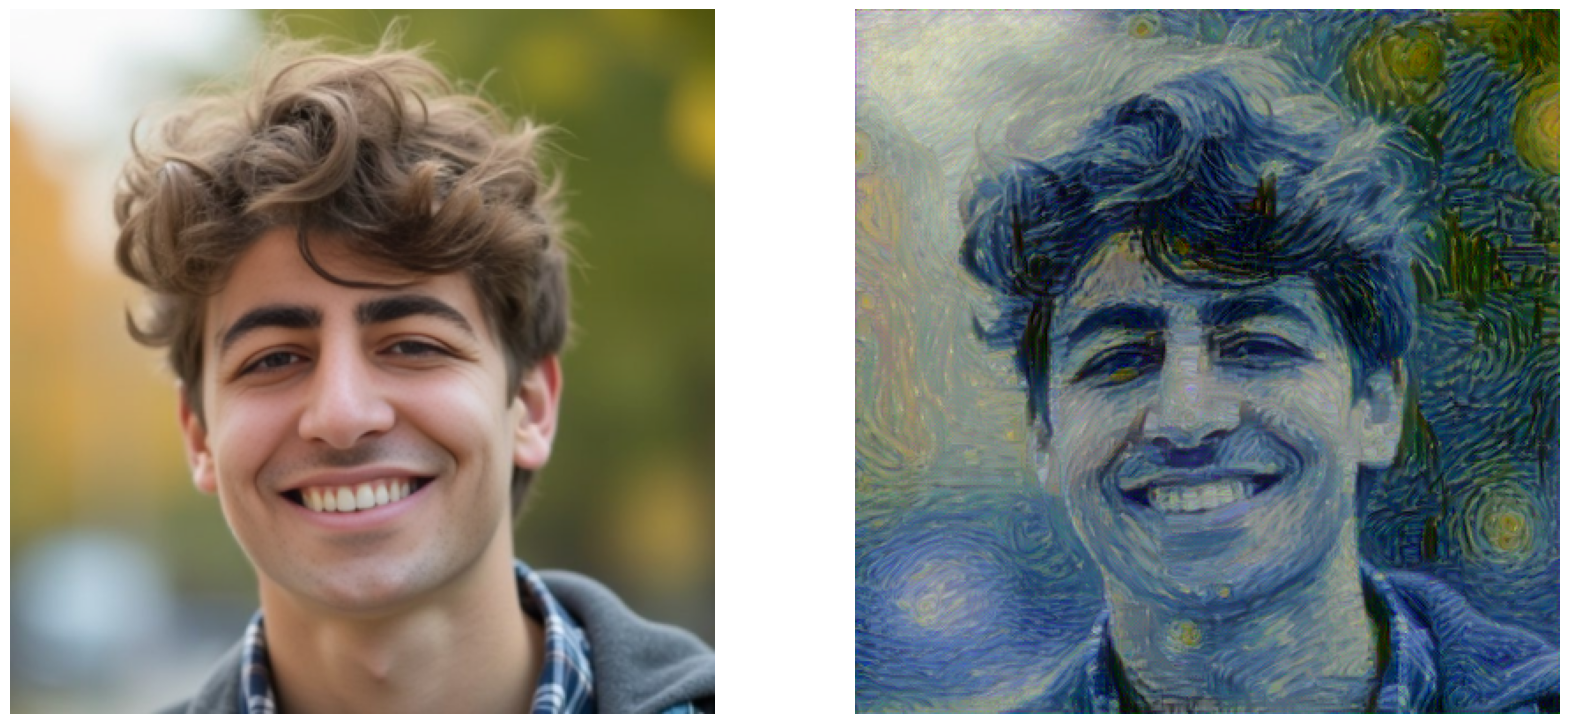

In [35]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(converter(main_img.cpu()))
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(converter(t.cpu()))
plt.axis("off");